In [18]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import sys
sys.path.insert(0, '/home/ruizhu/Documents/Projects/semanticInverse/train')

import torch
import numpy as np
from torch.autograd import Variable
import torch.optim as optim
import argparse
import random
import os
import models
import torchvision.utils as vutils
import utils
import dataLoader
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

parser = argparse.ArgumentParser()
# The locationi of training set
parser.add_argument('--dataRoot', default=None, help='path to input images')
parser.add_argument('--experiment', default=None, help='the path to store samples and models')
# The basic training setting
parser.add_argument('--nepoch0', type=int, default=14, help='the number of epochs for training')
parser.add_argument('--nepoch1', type=int, default=10, help='the number of epochs for training')

parser.add_argument('--batchSize0', type=int, default=16, help='input batch size')
parser.add_argument('--batchSize1', type=int, default=16, help='input batch size')

parser.add_argument('--imHeight0', type=int, default=240, help='the height / width of the input image to network')
parser.add_argument('--imWidth0', type=int, default=320, help='the height / width of the input image to network')
parser.add_argument('--imHeight1', type=int, default=240, help='the height / width of the input image to network')
parser.add_argument('--imWidth1', type=int, default=320, help='the height / width of the input image to network')

parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--deviceIds', type=int, nargs='+', default=[0, 1, 2], help='the gpus used for training network')
# Fine tune the network
parser.add_argument('--isFineTune', action='store_true', help='fine-tune the network')
parser.add_argument('--epochIdFineTune', type=int, default = 0, help='the training of epoch of the loaded model')
# The training weight
parser.add_argument('--albedoWeight', type=float, default=1.5, help='the weight for the diffuse component')
parser.add_argument('--normalWeight', type=float, default=1.0, help='the weight for the diffuse component')
parser.add_argument('--roughWeight', type=float, default=0.5, help='the weight for the roughness component')
parser.add_argument('--depthWeight', type=float, default=0.5, help='the weight for depth component')

# Cascae Level
parser.add_argument('--cascadeLevel', type=int, default=0, help='the casacade level')

# The detail network setting
opt = parser.parse_args('--cuda --dataRoot ../data/mini --batchSize0 1 --imHeight0 480 --imWidth0 640 --cascadeLevel 0 --experiment train_BRDF --deviceIds 0 1 2 3'.split())
print(opt)

Namespace(albedoWeight=1.5, batchSize0=1, batchSize1=16, cascadeLevel=0, cuda=True, dataRoot='../data/mini', depthWeight=0.5, deviceIds=[0, 1, 2, 3], epochIdFineTune=0, experiment='train_BRDF', imHeight0=480, imHeight1=240, imWidth0=640, imWidth1=320, isFineTune=False, nepoch0=14, nepoch1=10, normalWeight=1.0, roughWeight=0.5)


In [19]:
opt.gpuId = opt.deviceIds[0]

albeW, normW = opt.albedoWeight, opt.normalWeight
rougW = opt.roughWeight
deptW = opt.depthWeight

if opt.cascadeLevel == 0:
    opt.nepoch = opt.nepoch0
    opt.batchSize = opt.batchSize0
    opt.imHeight, opt.imWidth = opt.imHeight0, opt.imWidth0
elif opt.cascadeLevel == 1:
    opt.nepoch = opt.nepoch1
    opt.batchSize = opt.batchSize1
    opt.imHeight, opt.imWidth = opt.imHeight1, opt.imWidth1

if opt.experiment is None:
    opt.experiment = 'check_cascade%d_w%d_h%d' % (opt.cascadeLevel,
            opt.imWidth, opt.imHeight )
os.system('mkdir {0}'.format(opt.experiment) )
os.system('cp *.py %s' % opt.experiment )

opt.seed = 0
print("Random Seed: ", opt.seed )
random.seed(opt.seed )
torch.manual_seed(opt.seed )

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")



####################################
brdfDataset = dataLoader.BatchLoader( opt.dataRoot,
        imWidth = opt.imWidth, imHeight = opt.imHeight,
        cascadeLevel = opt.cascadeLevel )
brdfLoader = DataLoader(brdfDataset, batch_size = opt.batchSize,
        num_workers = 0, shuffle = True )

Random Seed:  0
Shape Num: 18
Image Num: 1146


In [20]:
from tqdm import tqdm
for i, dataBatch in tqdm(enumerate(brdfLoader)):
    print(i)
    break
    
#     print(dataBatch)
#     break

0it [00:00, ?it/s]

0


In [21]:
dataBatch.keys()

dict_keys(['albedo', 'normal', 'rough', 'depth', 'mask', 'mat_aggre_map', 'maskPath', 'segArea', 'segEnv', 'segObj', 'im', 'imPath'])

3914 1 930.8619227430555 int32 (480, 640, 3)


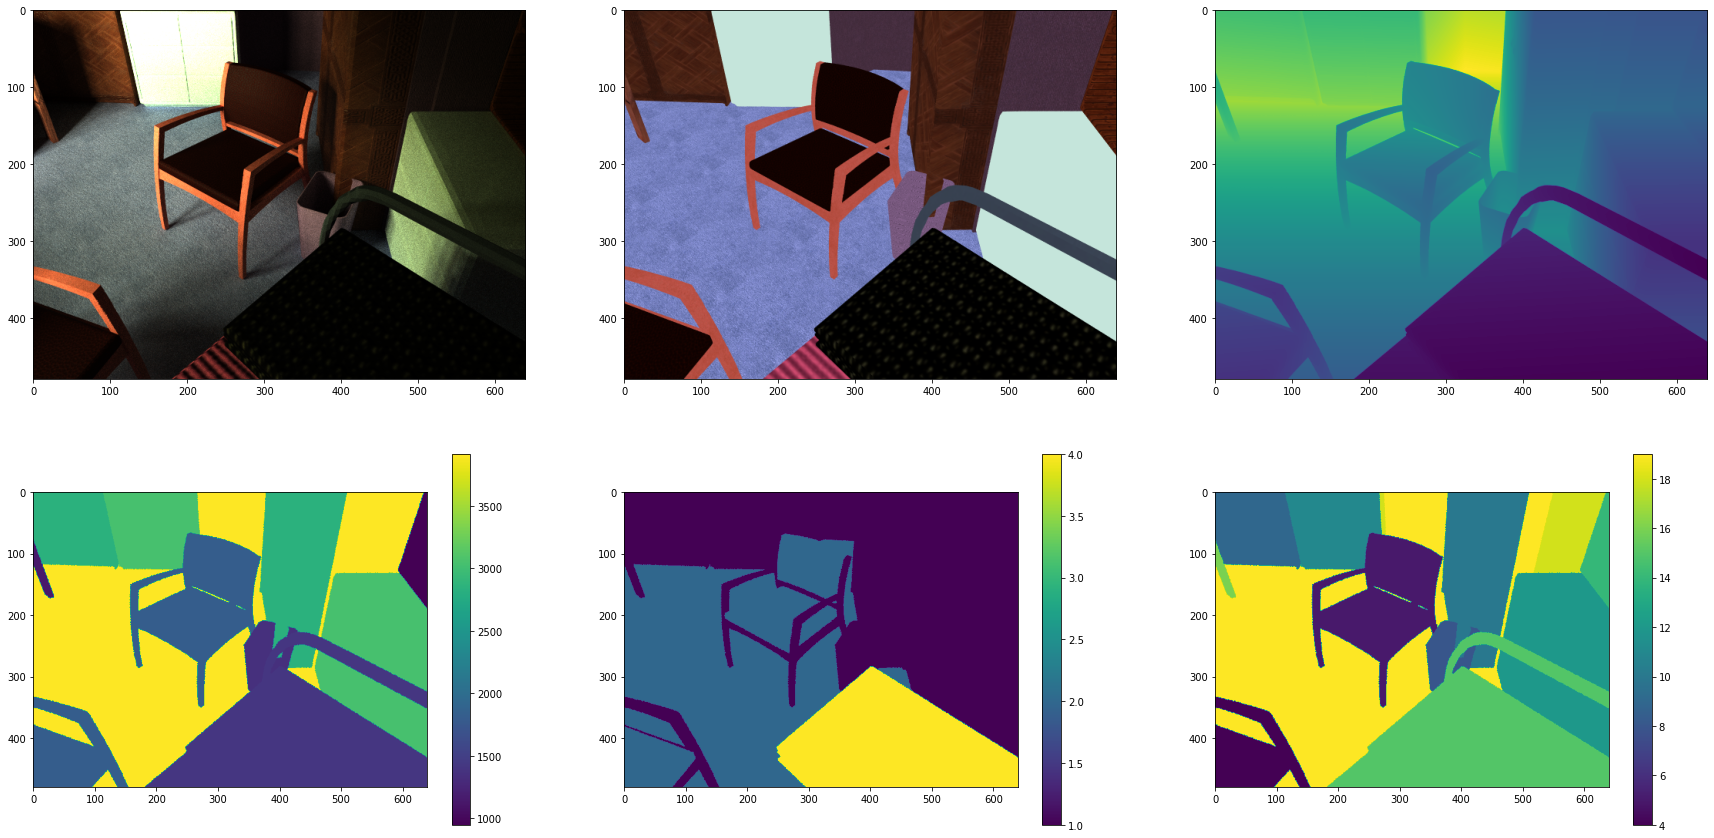

In [22]:
# mask_path = '../data/mini/main_xml1/scene0024_00/imdepth_2.dat'
# mask_path = '../data/mini/main_xml1/scene0024_00/immatPart_2.dat'

import struct
def loadBinary(imName, dtype=np.float32, if_resize=True):
    with open(imName, 'rb') as fIn:
        hBuffer = fIn.read(4)
        height = struct.unpack('i', hBuffer)[0]
        wBuffer = fIn.read(4)
        width = struct.unpack('i', wBuffer)[0]
        dBuffer = fIn.read(4 * 3 * width * height )
        depth = np.asarray(struct.unpack('i' * 3 * height * width, dBuffer), dtype=np.int32)
        depth = depth.reshape([height, width, 3] )
    return depth
            
import numpy as np
im = np.transpose(dataBatch['im'][0].numpy(), (1, 2, 0))
albedo = np.transpose(dataBatch['albedo'][0].numpy(), (1, 2, 0))
depth = dataBatch['depth'][0].numpy().squeeze()
objMask = dataBatch['mask'][0].numpy().squeeze()

# objMask = loadBinary(dataBatch['matMaskPath'][0], if_resize=False).squeeze()[:, :, 2]

print(np.amax(objMask), np.amin(objMask), np.mean(objMask), objMask.dtype, objMask.shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(30, 15))
plt.subplot(231)
plt.imshow(im)
plt.subplot(232)
plt.imshow(albedo)
plt.subplot(233)
plt.imshow(depth)
plt.subplot(234)
plt.imshow(objMask[:, :, 0])
plt.colorbar()
plt.subplot(235)
plt.imshow(objMask[:, :, 1])
plt.colorbar()
plt.subplot(236)
plt.imshow(objMask[:, :, 2])
plt.colorbar()
plt.show()

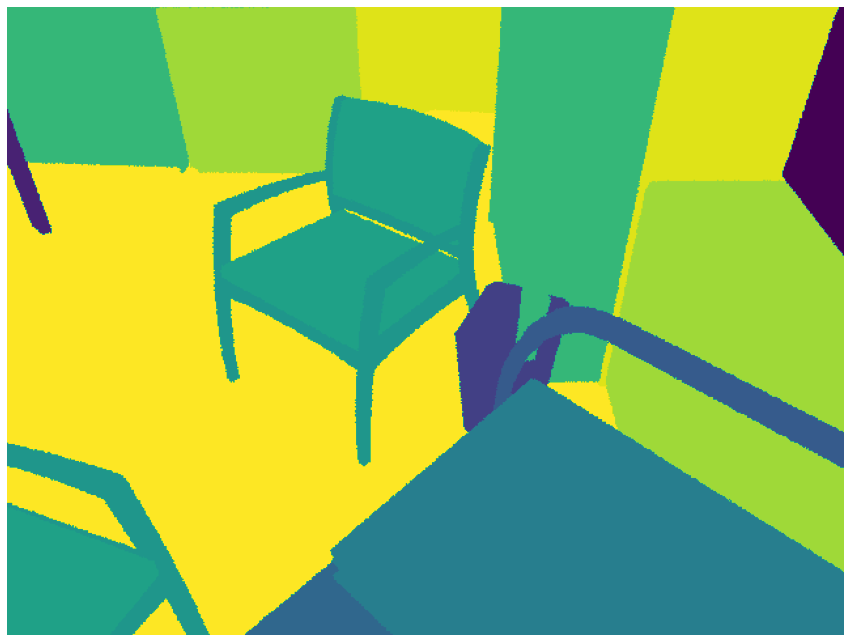

In [100]:
mat_aggre_map = dataBatch['mat_aggre_map'].numpy().squeeze()
plt.figure(figsize=(15, 15))
# plt.imshow(depth)
plt.imshow(mat_aggre_map)
# plt.colorbar()
plt.axis('off')
plt.show()

In [50]:
list(mat_idxes)

[1, 2]

949 [1] 1 4808


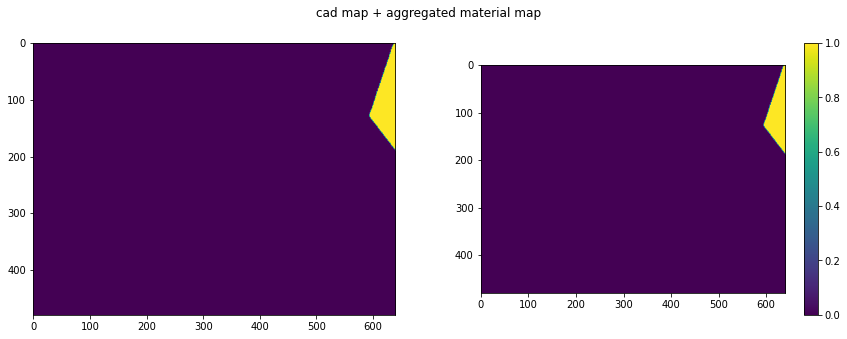

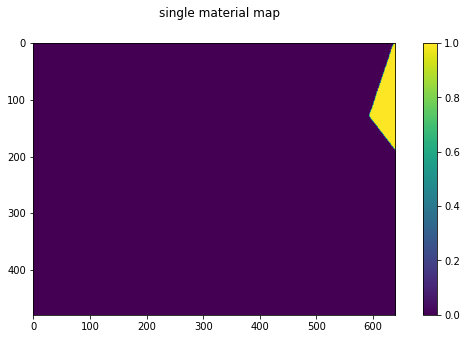

1148 [1] 2 1080


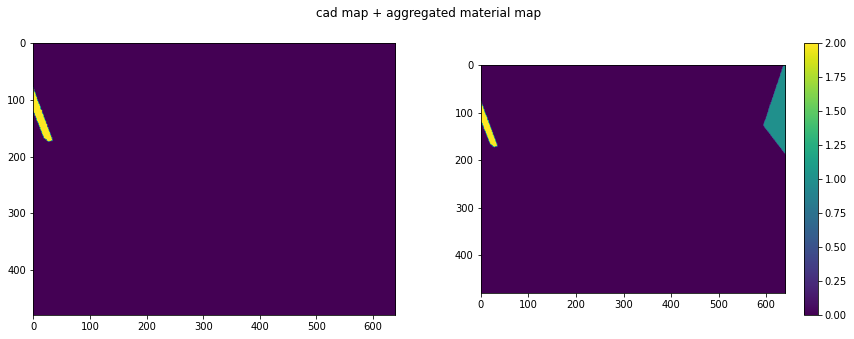

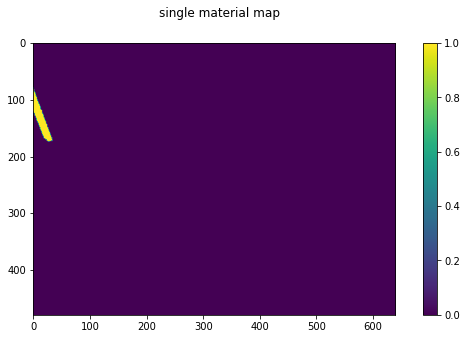

1361 [1] 3 4461


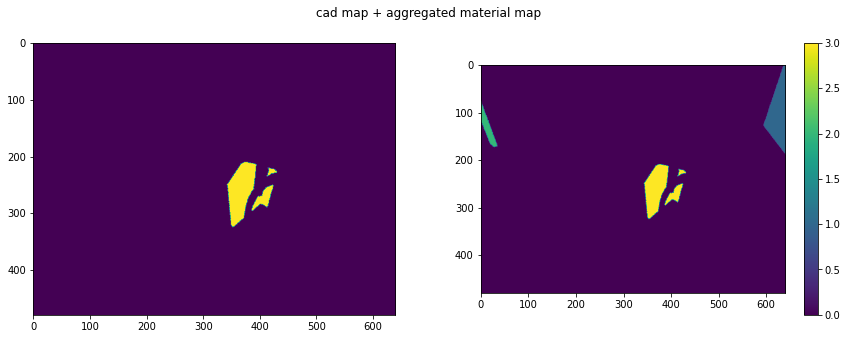

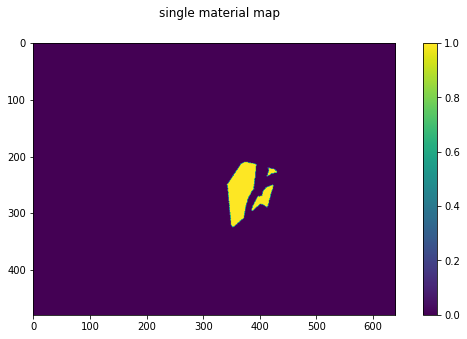

1419 [1 2 4] 6 57771


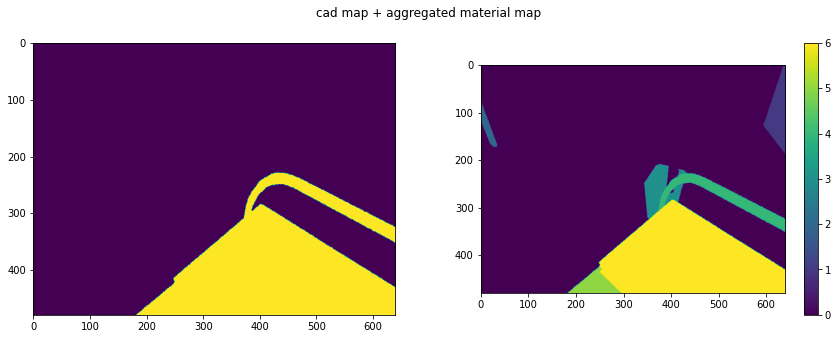

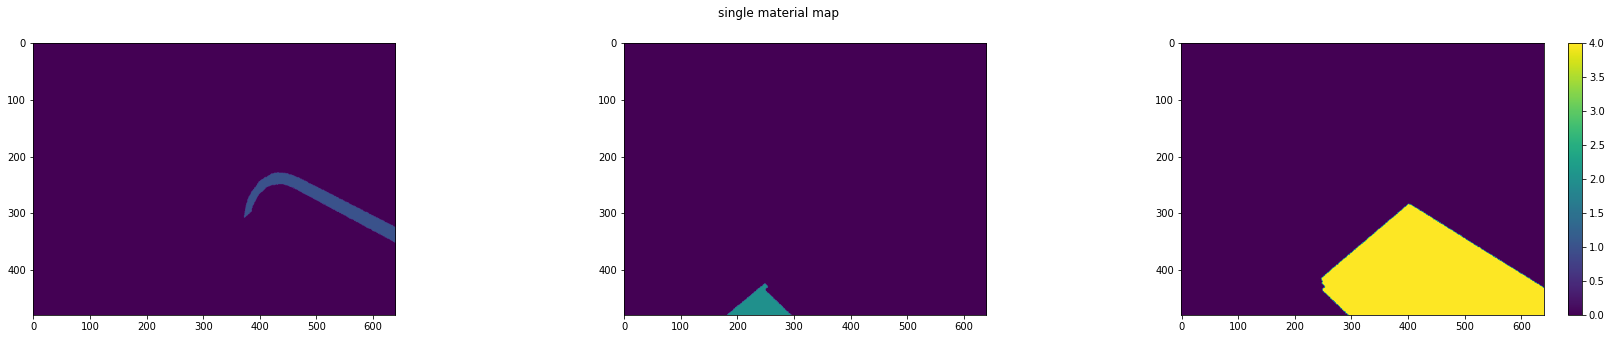

1819 [1 2] 8 40917


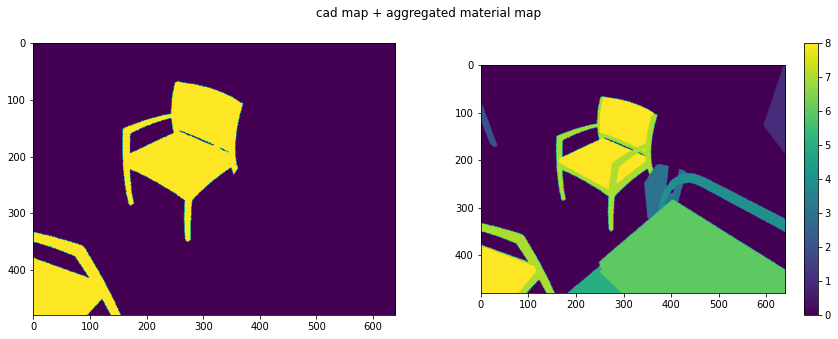

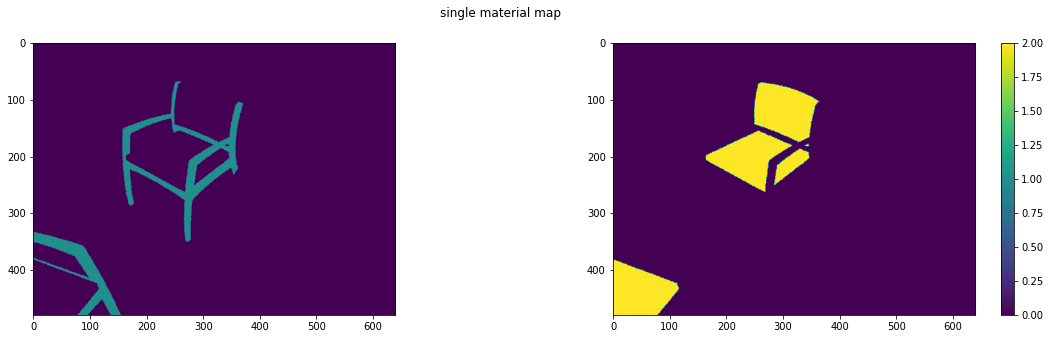

2839 [1] 9 42342


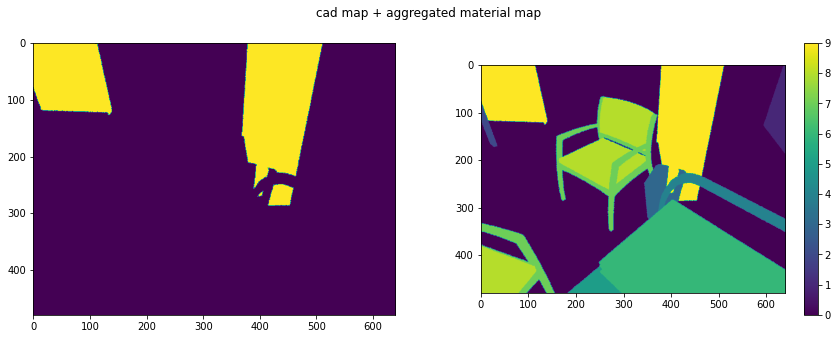

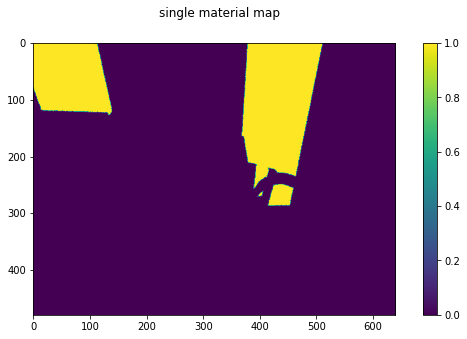

2976 [1] 10 30


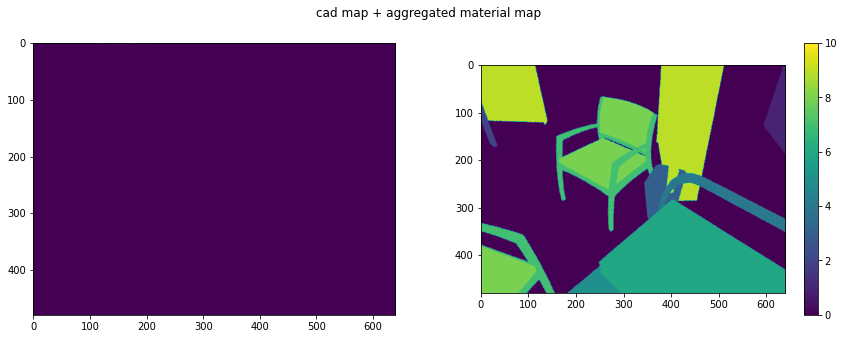

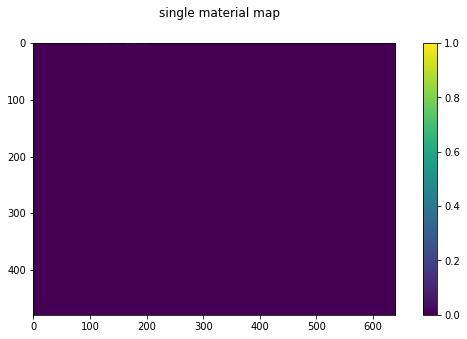

3051 [1] 11 52345


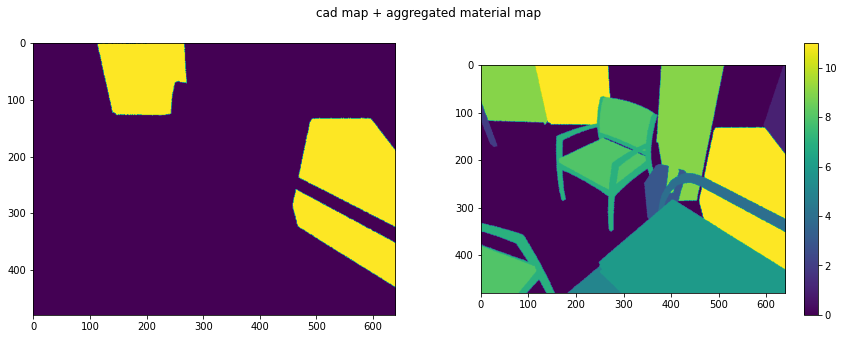

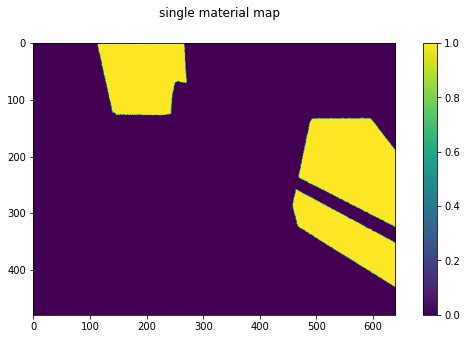

3914 [1 2] 13 103446


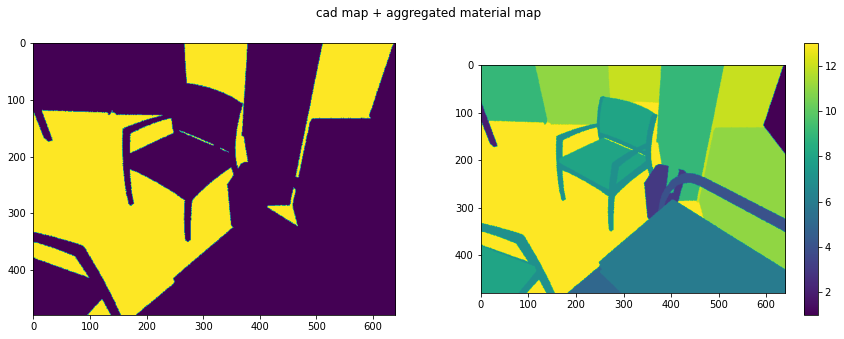

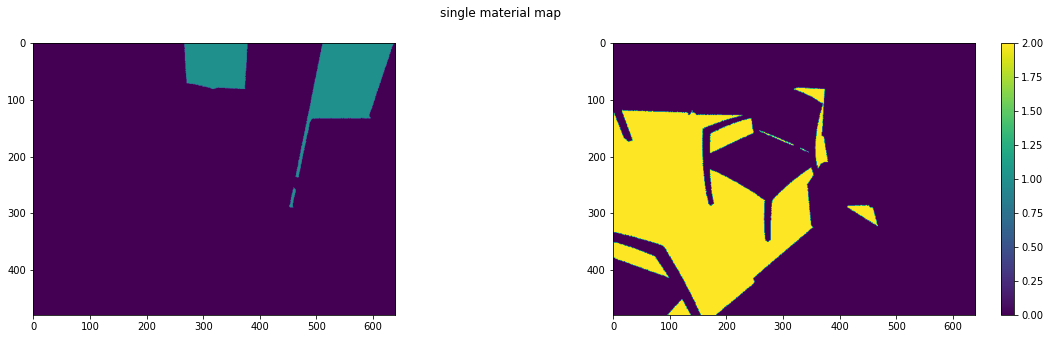

In [98]:
cad_map = objMask[:, :, 0] # first channel: cad_id map
mat_idx_map = objMask[:, :, 1] # second channel: material INDEX map inside each obj

mat_aggre_map = np.zeros_like(cad_map)
cad_ids = np.unique(cad_map)
num_mats = 1
for cad_id in cad_ids: # go over each cad model
#     if cad_id != 2976:
#         continue
    cad_mask = cad_map == cad_id
    mat_index_map_cad = mat_idx_map[cad_mask] # get the internal material index map for that object
    mat_idxes = np.unique(mat_index_map_cad)
    
    # copy the internal material index map + offset (num_mats) to the new global material index map
    # this is where yu-ying can change to look for the material ID based on the cad_id and internal material INDEX map (mat_map_cad)
#     mat_aggre_map[cad_mask] = mat_index_map_cad + num_mats

    cad_single_map = np.zeros_like(cad_map)
    cad_single_map[cad_mask] = mat_idx_map[cad_mask]
    for i, mat_idx in enumerate(mat_idxes):
#         mat_single_map = np.zeros_like(cad_map)
        mat_aggre_map[cad_single_map==mat_idx] = num_mats
        num_mats += 1
    
#     num_mats = num_mats + max(mat_idxes)
    
    print(cad_id, mat_idxes, num_mats-1, np.sum(cad_mask))
    
    fig1 = plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(cad_mask)
    plt.subplot(122)
    plt.imshow(mat_aggre_map)
    plt.colorbar()
    fig1.suptitle('cad map + aggregated material map')
    plt.show()
    
    fig2 = plt.figure(figsize=(10*len(mat_idxes), 5))
    cad_single_map = np.zeros_like(cad_map)
    cad_single_map[cad_mask] = mat_idx_map[cad_mask]
    for i, mat_idx in enumerate(mat_idxes):
        mat_single_map = np.zeros_like(cad_map)
        mat_single_map[cad_single_map==mat_idx] = mat_idx
        plt.subplot(1, len(mat_idxes), i+1)
        plt.imshow(mat_single_map, vmin=0, vmax=np.max(mat_idxes))
    plt.colorbar()
    fig2.suptitle('single material map')
    plt.show()
    
#     break

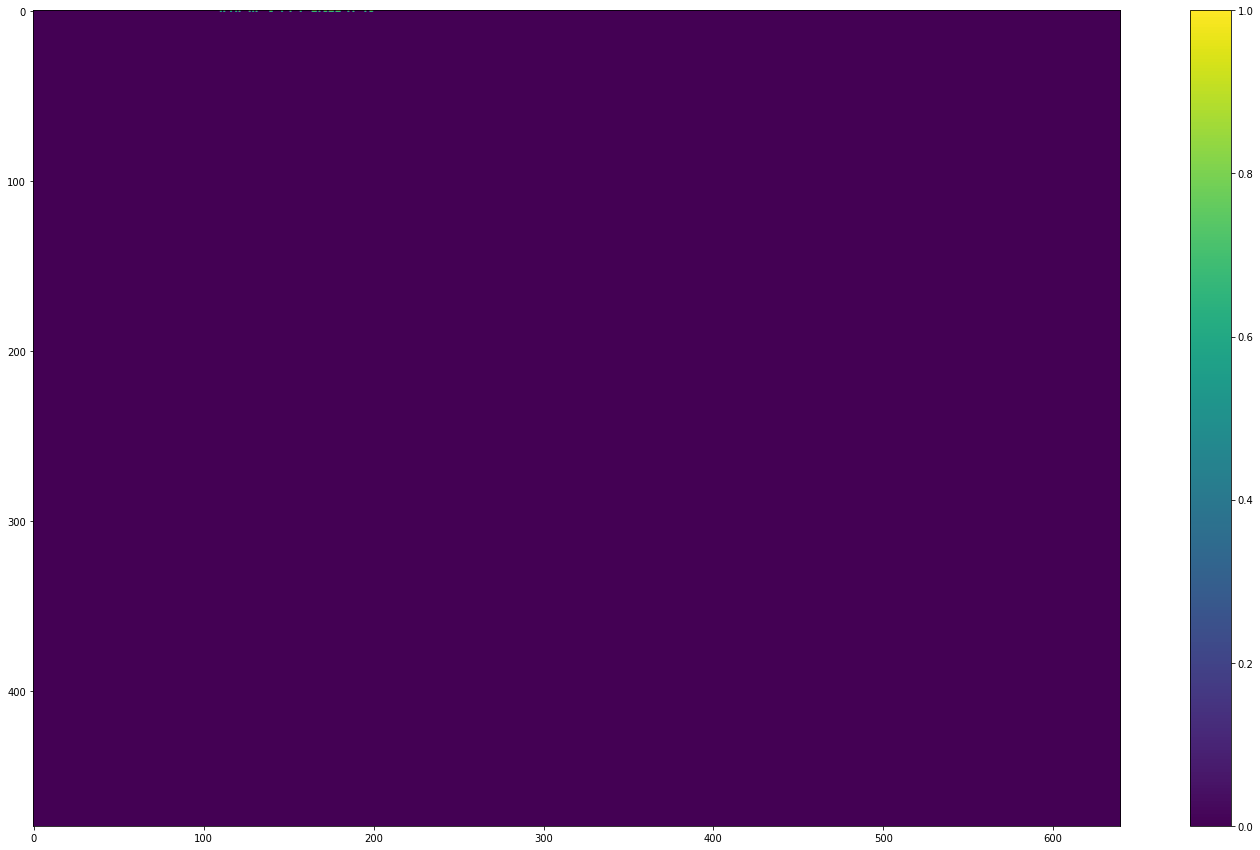

In [87]:
np.where(cad_mask==True)
fig1 = plt.figure(figsize=(25, 15))
plt.imshow(cad_mask)
plt.colorbar()
plt.show()

In [15]:
cad_ids

array([ 448,  464, 2116, 2551, 2639, 2774, 3300], dtype=int32)

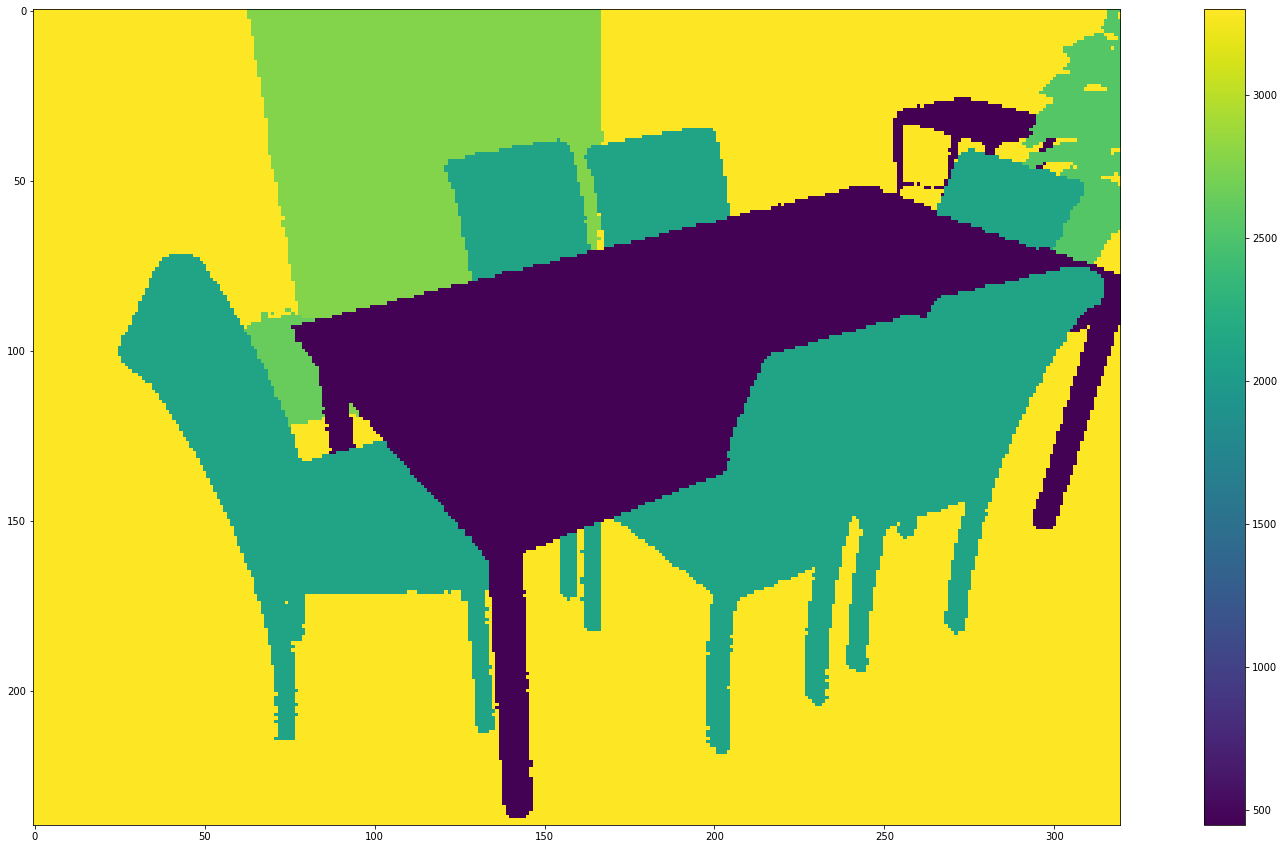

In [9]:
plt.figure(figsize=(30, 15))
plt.imshow(objMask[:, :, 0])
plt.colorbar()
plt.show()

In [12]:
a = objMask[:, :, 0]
np.unique(a)

array([ 448,  464, 2116, 2551, 2639, 2774, 3300], dtype=int32)